# classifier
Classifies each tweet according to the train set, which was classified by collaborators of the Infodengue project. 

Observations:
* Do not use stemming, because of the text content of tweets.
* For sklearn, check the text preprocessing
* Using tweet tokenizer from nltk
* Using only TF for preprocessing
* baseline: random forest, logistic, xgboost

16/12
* usar spacy para fazer marcacao sintatica. variavel part of speech tag dobraria numero de colunas
* achou numero de 0.79 de recall e 0.4 de precision muito baixo
* usar shap para interpretabilidade de xgboost

usar word2vec (notebook separado)
* ref: 
    * https://github.com/fccoelho/text-mining-cientistas-sociais
    * kaggle-quora
    * SRI

In [1]:
import os
import pandas as pd
import numpy as np
#import pickle
from collections import Counter
#import math
import nltk
#import requests
#import html
#from datetime import datetime, timedelta, date
import string
import json
import matplotlib.pyplot as plt
import seaborn as sns
#from sklearn.feature_extraction.text import TfidfVectorizer
#from sklearn.model_selection import cross_val_score
#import statsmodels as sm

from gensim.models import Word2Vec, word2vec

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
outputs = "../outputs/"

In [3]:
classifications = pd.read_csv(os.path.join('../outputs/from_anvil/', 'classifications_finished.csv'))

In [4]:
classifications = classifications.groupby(by='str_id').sum()
classifications['class'] = classifications['relevance'].apply(lambda x: 1 if x>=4 else 0)
classifications['class_threshold3'] = classifications['relevance'].apply(lambda x: 1 if x>=3 else 0)
classifications.reset_index(inplace=True)
classifications.rename(columns = {'str_id': 'id'}, inplace=True)

# get text from original database

In [5]:
text_data = pd.read_json(os.path.join(outputs, "tweets_filtered.json"))
text_data.rename(columns = {'_id': 'id'}, inplace=True)

In [6]:
data = pd.merge(classifications, text_data, on='id')
data.drop(columns=['tid'], inplace=True)
data

,id,relevance,class,class_threshold3,text,text_original
0,699069305468551169,2,0,0,Brasil tera 55 mil militares nas ruas para com...,Brasil terá 55 mil militares nas ruas para com...
1,699164279472263170,3,0,1,Depois do exercito abandonar o combate aos foc...,Depois do exército abandonar o combate aos foc...
2,699264346304618496,1,0,0,Farmaceuticos recebem treinamento sobre dengue...,Farmacêuticos recebem treinamento sobre dengue...
3,699266282646994944,3,0,1,Farmaceuticos recebem treinamento sobre dengue...,Farmacêuticos recebem treinamento sobre dengue...
4,699315864122892288,0,0,0,RT @g1: Morador do DF faz 'rap da dengue': 'Ag...,RT @g1: Morador do DF faz 'rap da dengue': 'Ag...
...,...,...,...,...,...,...
995,1000740798114222081,0,0,0,RT @EnquetesFutebas: So eu acho que o Diogo Ba...,RT @EnquetesFutebas: Só eu acho que o Diogo Ba...
996,1000763927146450944,4,1,1,"Nao recomendo ninguem a pegar Zika, serio","Não recomendo ninguém a pegar Zika, serio"
997,1000764889361780736,0,0,0,@_ThiagoAndrei E deixa minha zika pra traz ???...,@_ThiagoAndrei E deixa minha zika pra traz ???...
998,1000841034488778752,0,0,0,kkkkkkkkk ele tem problema mas eu amo https://...,kkkkkkkkk ele tem problema mas eu amo https://...


In [8]:
for col in ['text', 'text_original']:
    data[col] = data[col].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)).lower())

# build columns for tokens and ngrams

In [10]:
from nltk.tokenize import TweetTokenizer
tknzr = TweetTokenizer()

In [11]:
data['tokens'] = data['text'].apply(lambda x: tknzr.tokenize(x))

In [12]:
from gensim.models.phrases import Phrases, Phraser

Some functions to test bigrams
```python
test = [['my', 'name', 'is', 'frank'], ['her', 'friend', 'hates', 'cats'], ['my', 'name', 'is', 'paul'], 
        ['her', 'name', 'is', 'carol']]
phrases = Phrases(sentences, min_count=1, threshold=1)
bigram = Phraser(phrases)
for sent in bigram[sentences]:
    print(sent, 'ok')
print(phrases.vocab)
print(phrases[['my', 'name', 'is', 'carol']])
```

In [13]:
bigram = Phraser.load(os.path.join(outputs, "bigram_model.pkl"))

In [14]:
data['tokens_bigrams'] = data['tokens'].apply(lambda x: bigram[x])

In [15]:
print(list(data['tokens_bigrams'])[:5])

[['brasil_tera', '55_mil', 'militares_nas', 'ruas_para', 'combater_aedes', 'aegypt', 'a_partir', 'de', 'hoje_httpstco', '4jnbywfdvt'], ['depois_do', 'exercito', 'abandonar_o', 'combate_aos', 'focos_de', 'agua_parada', 'e', 'ao', 'zika_virus', 'afirmando_que', 'questoes', 'que', 'httpstcoh', '3vffbc08n'], ['farmaceuticos_recebem', 'treinamento_sobre', 'dengue', 'zika', 'e_chikungunya', 'profissionais_de', 'araraquara_e', 'sao_joao', 'ser', 'httpstcocsac', '4r0f29'], ['farmaceuticos_recebem', 'treinamento_sobre', 'dengue', 'zika', 'e_chikungunya', 'profissionais_de', 'araraquara_e', 'sao_joao', 'ser', 'httpstconzq', '8hllm8a'], ['rt_g1', 'morador', 'do_df', 'faz_rap', 'da_dengue', 'agora_tome', 'cuidado_com', 'aedes', 'pode_cre', 'httpstcoysimqn_4efj', 'httpstcopj_5yjwrzjg']]


# basic exploration

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 8 columns):
id                  1000 non-null int64
relevance           1000 non-null int64
class               1000 non-null int64
class_threshold3    1000 non-null int64
text                1000 non-null object
text_original       1000 non-null object
tokens              1000 non-null object
tokens_bigrams      1000 non-null object
dtypes: int64(4), object(4)
memory usage: 70.3+ KB


In [17]:
data.describe()

,id,relevance,class,class_threshold3
count,1.000000e+03,1000.000000,1000.000000,1000.000000
mean,8.387557e+17,1.166000,0.141000,0.207000
std,1.140594e+17,1.659276,0.348196,0.405358
min,6.990693e+17,0.000000,0.000000,0.000000
25%,7.094149e+17,0.000000,0.000000,0.000000
50%,8.460180e+17,0.000000,0.000000,0.000000
75%,9.829813e+17,2.000000,0.000000,0.000000
max,1.000886e+18,6.000000,1.000000,1.000000


# check if data is unbalanced

**Data is unbalanced!**

### Threshold 4
fazer oversampling?

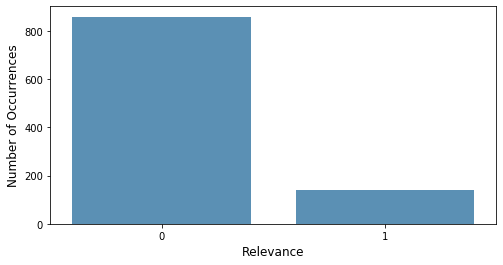

In [15]:
color = sns.color_palette()
classif = data['class'].value_counts()
plt.figure(figsize=(8,4))
sns.barplot(classif.index, classif.values, alpha=0.8, color=color[0])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Relevance', fontsize=12)
plt.show()

In [16]:
data['class'].value_counts()

0    859
1    141
Name: class, dtype: int64

### Threshold 3

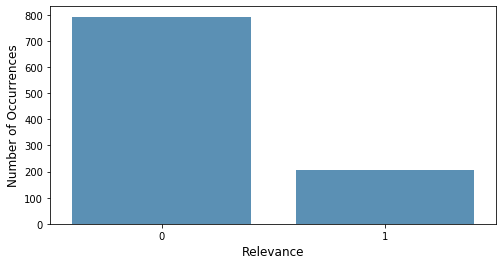

In [17]:
color = sns.color_palette()
classif = data['class_threshold3'].value_counts()
plt.figure(figsize=(8,4))
sns.barplot(classif.index, classif.values, alpha=0.8, color=color[0])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Relevance', fontsize=12)
plt.show()

In [18]:
data['class_threshold3'].value_counts()

0    793
1    207
Name: class_threshold3, dtype: int64

# apply word2vec

In [18]:
model = Word2Vec.load('../outputs/virus_tweets.w2v')

In [19]:
data['text'] = data['text'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)).lower())

In [20]:
n_dimensions = len(model.wv['dengue'])
w2v_data = pd.DataFrame()
for index, row in data.iterrows():
    tid = row[0]
    text = row[5]
    sum_w2v = np.zeros(n_dimensions)
    for word in tknzr.tokenize(text):
        if word in model.wv.vocab:
            sum_w2v += model.wv[word]
    avg_w2v = sum_w2v/n_dimensions
    w2v_row = pd.DataFrame(data=avg_w2v).transpose()
    w2v_row['id'] = tid
    w2v_data = w2v_data.append(w2v_row)
w2v_data.head()

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,id
0,0.180816,-0.251217,-0.187524,0.157219,-0.048757,-0.163081,0.316214,-0.335298,0.114673,0.106486,...,0.219764,-0.193622,0.134398,0.071353,-0.397907,0.236137,0.049874,0.139613,0.479017,699069305468551169
0,0.187050,-0.225580,-0.056113,0.222188,-0.162187,-0.359365,0.190656,-0.266675,0.423236,-0.146147,...,-0.097624,-0.174353,0.034669,0.103584,-0.287881,0.224616,0.072400,0.081860,0.418087,699164279472263170
0,0.076202,-0.346804,-0.040145,0.084669,-0.071931,-0.079370,0.161752,-0.156063,0.230844,-0.041145,...,0.022997,-0.116464,0.217569,0.036479,-0.255551,0.184222,0.041002,0.252506,0.215646,699264346304618496
0,0.075017,-0.344677,-0.040631,0.084277,-0.071954,-0.079764,0.161773,-0.157080,0.230336,-0.040453,...,0.022942,-0.116199,0.218128,0.035412,-0.255835,0.184413,0.041305,0.253625,0.214270,699266282646994944
0,-0.003375,-0.173625,0.064493,0.126731,-0.145318,-0.216617,0.175384,-0.138079,0.402568,-0.000983,...,-0.100925,-0.156506,0.063525,0.103889,-0.446541,0.093477,-0.069528,0.021291,0.142325,699315864122892288


In [21]:
data = pd.merge(data, w2v_data, left_on='id', right_on='id')
print('df size is:', len(data))
data.head()

df size is: 1000


,id,relevance,class,class_threshold3,text,text_original,tokens,tokens_bigrams,0,1,...,90,91,92,93,94,95,96,97,98,99
0,699069305468551169,2,0,0,brasil tera 55 mil militares nas ruas para com...,brasil terá 55 mil militares nas ruas para com...,"[brasil, tera, 55, mil, militares, nas, ruas, ...","[brasil_tera, 55_mil, militares_nas, ruas_para...",0.180816,-0.251217,...,-0.124944,0.219764,-0.193622,0.134398,0.071353,-0.397907,0.236137,0.049874,0.139613,0.479017
1,699164279472263170,3,0,1,depois do exercito abandonar o combate aos foc...,depois do exército abandonar o combate aos foc...,"[depois, do, exercito, abandonar, o, combate, ...","[depois_do, exercito, abandonar_o, combate_aos...",0.187050,-0.225580,...,-0.093291,-0.097624,-0.174353,0.034669,0.103584,-0.287881,0.224616,0.072400,0.081860,0.418087
2,699264346304618496,1,0,0,farmaceuticos recebem treinamento sobre dengue...,farmacêuticos recebem treinamento sobre dengue...,"[farmaceuticos, recebem, treinamento, sobre, d...","[farmaceuticos_recebem, treinamento_sobre, den...",0.076202,-0.346804,...,-0.082189,0.022997,-0.116464,0.217569,0.036479,-0.255551,0.184222,0.041002,0.252506,0.215646
3,699266282646994944,3,0,1,farmaceuticos recebem treinamento sobre dengue...,farmacêuticos recebem treinamento sobre dengue...,"[farmaceuticos, recebem, treinamento, sobre, d...","[farmaceuticos_recebem, treinamento_sobre, den...",0.075017,-0.344677,...,-0.083351,0.022942,-0.116199,0.218128,0.035412,-0.255835,0.184413,0.041305,0.253625,0.214270
4,699315864122892288,0,0,0,rt g1 morador do df faz rap da dengue agora to...,rt g1 morador do df faz rap da dengue agora to...,"[rt, g1, morador, do, df, faz, rap, da, dengue...","[rt_g1, morador, do_df, faz_rap, da_dengue, ag...",-0.003375,-0.173625,...,-0.047464,-0.100925,-0.156506,0.063525,0.103889,-0.446541,0.093477,-0.069528,0.021291,0.142325


# Data split

In [22]:
from sklearn.model_selection import train_test_split

In [23]:
data = data.rename(columns={"class": "y1", "class_threshold3": "y2"})

In [25]:
x_variables = data.columns[8:]
x_variables

Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71,
       72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89,
       90, 91, 92, 93, 94, 95, 96, 97, 98, 99],
      dtype='object')

In [26]:
#ys = data.iloc[:, 2:4]
y = data.loc[:, 'y2']
#y = data.iloc[:, 3:4]
X = data.iloc[:, 8:]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=0, shuffle=False)

In [27]:
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.180816,-0.251217,-0.187524,0.157219,-0.048757,-0.163081,0.316214,-0.335298,0.114673,0.106486,...,-0.124944,0.219764,-0.193622,0.134398,0.071353,-0.397907,0.236137,0.049874,0.139613,0.479017
1,0.187050,-0.225580,-0.056113,0.222188,-0.162187,-0.359365,0.190656,-0.266675,0.423236,-0.146147,...,-0.093291,-0.097624,-0.174353,0.034669,0.103584,-0.287881,0.224616,0.072400,0.081860,0.418087
2,0.076202,-0.346804,-0.040145,0.084669,-0.071931,-0.079370,0.161752,-0.156063,0.230844,-0.041145,...,-0.082189,0.022997,-0.116464,0.217569,0.036479,-0.255551,0.184222,0.041002,0.252506,0.215646
3,0.075017,-0.344677,-0.040631,0.084277,-0.071954,-0.079764,0.161773,-0.157080,0.230336,-0.040453,...,-0.083351,0.022942,-0.116199,0.218128,0.035412,-0.255835,0.184413,0.041305,0.253625,0.214270
4,-0.003375,-0.173625,0.064493,0.126731,-0.145318,-0.216617,0.175384,-0.138079,0.402568,-0.000983,...,-0.047464,-0.100925,-0.156506,0.063525,0.103889,-0.446541,0.093477,-0.069528,0.021291,0.142325


In [29]:
y

0      0
1      1
2      0
3      1
4      0
      ..
995    0
996    1
997    0
998    0
999    0
Name: y2, Length: 1000, dtype: int64

# Oversampling minority class
Tested only on 1 ML model

In [104]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_traincv_res, y_traincv_res = smote.fit_sample(X_train, y_train)

# Machine Learning, Baseline
Using Logistic regression and Random Forest as baselines

In [33]:
from sklearn.preprocessing import StandardScaler, Imputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, confusion_matrix, accuracy_score

### Logistic Regression

In [101]:
from sklearn.linear_model import LogisticRegression

In [109]:
# Setup the pipeline
steps = [('scaler', StandardScaler()),
         ('logreg', LogisticRegression())]

pipeline = Pipeline(steps)

#LogisticRegression()

# Specify the hyperparameter space
c_space = np.logspace(-5, 1, 20)
parameters = {'logreg__C': c_space, 
              'logreg__penalty': ['l1', 'l2'],
              'logreg__random_state':[42]}

# Instantiate the GridSearchCV object
clf_logreg = GridSearchCV(pipeline,parameters, cv=5, scoring='recall')

# Fit to the training set
clf_logreg.fit(X_train, y_train)

# Compute and print metrics
print("\nTUNED MODEL PARAMETERS:\n {}".format(clf_logreg.best_params_))
print("\nTUNED RECALL:\n {}".format(clf_logreg.best_score_))


TUNED MODEL PARAMETERS:
 {'logreg__C': 8.858667904100833e-05, 'logreg__penalty': 'l2', 'logreg__random_state': 42}

TUNED RECALL:
 0.5165345622119816


In [110]:
logreg_best = clf_logreg.best_params_

#### repeat with oversampling

In [111]:
# Fit to the training set
clf_logreg.fit(X_traincv_res, y_traincv_res)

# Compute and print metrics
print("\nTUNED MODEL PARAMETERS:\n {}".format(clf_logreg.best_params_))
print("\nTUNED RECALL:\n {}".format(clf_logreg.best_score_))


TUNED MODEL PARAMETERS:
 {'logreg__C': 1.1288378916846884, 'logreg__penalty': 'l2', 'logreg__random_state': 42}

TUNED RECALL:
 0.8688524590163934


In [112]:
logreg_best_smote = clf_logreg.best_params_

### Random Forest

In [28]:
from sklearn.ensemble import RandomForestClassifier

In [103]:
# Setup the pipeline
steps = [('scaler', StandardScaler()),
         ('rfc', RandomForestClassifier())]

pipeline = Pipeline(steps)

# Specify the hyperparameter space
parameters = {'rfc__max_features':[1, 2, "auto", "log2", None],
              'rfc__n_estimators':[300],
              'rfc__random_state':[42]}

clf_rforest = GridSearchCV(pipeline,parameters, cv=5, scoring='recall')

clf_rforest.fit(X_train, y_train)

print("\nTUNED MODEL PARAMETERS:\n {}".format(clf_rforest.best_params_))
print("\nTUNED RECALL:\n {}".format(clf_rforest.best_score_))


TUNED MODEL PARAMETERS:
 {'rfc__max_features': None, 'rfc__n_estimators': 300, 'rfc__random_state': 42}

TUNED RECALL:
 0.20534101382488482


# Machine Learning, other models

### svm

In [90]:
from sklearn import svm

In [93]:
# Setup the pipeline
steps = [('scaler', StandardScaler()),
         ('svc', svm.SVC())]

pipeline = Pipeline(steps)

# Specify the hyperparameter space
parameters = {'svc__kernel': ['linear', 'poly'],
              'svc__C': np.linspace(0.1,2,10),
              'svc__degree': [2,3,4],
              'svc__gamma': np.logspace(-5, 0, 10),
              'svc__random_state':[42]}

clf_svc = GridSearchCV(pipeline,parameters, cv=5, scoring='recall')

clf_svc.fit(X_train, y_train)

print("\nTUNED MODEL PARAMETERS:\n {}".format(clf_svc.best_params_))
print("\nTUNED RECALL:\n {}".format(clf_svc.best_score_))


TUNED MODEL PARAMETERS:
 {'svc__C': 1.788888888888889, 'svc__degree': 2, 'svc__gamma': 1e-05, 'svc__kernel': 'linear', 'svc__random_state': 42}

TUNED RECALL:
 0.5364132104454685


### adaboost

In [94]:
from sklearn.ensemble import AdaBoostClassifier

In [97]:
steps = [('scaler', StandardScaler()),
         ('abc', AdaBoostClassifier())]

pipeline = Pipeline(steps)

parameters = {'abc__n_estimators': [300],
              'abc__random_state':[42]}

clf_abc = GridSearchCV(pipeline,parameters, cv=5, scoring='recall')

clf_abc.fit(X_train, y_train)

print("\nTUNED MODEL PARAMETERS:\n {}".format(clf_abc.best_params_))
print("\nTUNED RECALL:\n {}".format(clf_abc.best_score_))


TUNED MODEL PARAMETERS:
 {'abc__n_estimators': 300, 'abc__random_state': 42}

TUNED RECALL:
 0.3639677419354838


### gradient boosting

In [48]:
from sklearn.ensemble import GradientBoostingClassifier

In [49]:
steps = [('scaler', StandardScaler()),
         ('gbc', GradientBoostingClassifier())]

pipeline = Pipeline(steps)

parameters = {'gbc__n_estimators': [300],
              'gbc__random_state':[42]}


clf_gbc = GridSearchCV(pipeline, parameters, cv=5, scoring='recall')

clf_gbc.fit(X_train, y_train)

print("\nTUNED MODEL PARAMETERS:\n {}".format(clf_gbc.best_params_))
print("\nTUNED RECALL:\n {}".format(clf_gbc.best_score_))


TUNED MODEL PARAMETERS:
 {'gbc__n_estimators': 300, 'gbc__random_state': 42}

TUNED RECALL:
 0.3043533026113671


### xgboost

In [28]:
import xgboost as xgb

In [29]:
# Set our parameters for xgboost
params = {}
params['objective'] = 'reg:squarederror'
params['eval_metric'] = 'aucpr'
params['eta'] = 0.02
params['max_depth'] = 10

d_train = xgb.DMatrix(X_train, label=y_train)
d_test = xgb.DMatrix(X_test, label=y_test)

watchlist = [(d_train, 'train'), (d_test, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=50, verbose_eval=10)

[0]	train-aucpr:0.97042	valid-aucpr:0.260231
Multiple eval metrics have been passed: 'valid-aucpr' will be used for early stopping.

Will train until valid-aucpr hasn't improved in 50 rounds.
[10]	train-aucpr:0.998915	valid-aucpr:0.360895
[20]	train-aucpr:1	valid-aucpr:0.388403
[30]	train-aucpr:1	valid-aucpr:0.385397
[40]	train-aucpr:1	valid-aucpr:0.389419
[50]	train-aucpr:1	valid-aucpr:0.389876
[60]	train-aucpr:1	valid-aucpr:0.394523
[70]	train-aucpr:1	valid-aucpr:0.393382
[80]	train-aucpr:1	valid-aucpr:0.396373
[90]	train-aucpr:1	valid-aucpr:0.399911
[100]	train-aucpr:1	valid-aucpr:0.416427
[110]	train-aucpr:1	valid-aucpr:0.431052
[120]	train-aucpr:1	valid-aucpr:0.432278
[130]	train-aucpr:1	valid-aucpr:0.426353
[140]	train-aucpr:1	valid-aucpr:0.428471
[150]	train-aucpr:1	valid-aucpr:0.425503
[160]	train-aucpr:1	valid-aucpr:0.427718
Stopping. Best iteration:
[115]	train-aucpr:1	valid-aucpr:0.435724



In [30]:
def use_threshold(value):
    if value > 0.2: value = 1
    else: value = 0
    return value

In [31]:
p_test = bst.predict(d_test)
y_pred = np.array(list((map(use_threshold, p_test))))

In [34]:
accuracy_score(y_test, y_pred)

0.6833333333333333

In [35]:
print("\nCLASSIFICATION_REPORT:\n", classification_report(y_test, y_pred))


CLASSIFICATION_REPORT:
               precision    recall  f1-score   support

           0       0.91      0.68      0.78       244
           1       0.33      0.70      0.45        56

    accuracy                           0.68       300
   macro avg       0.62      0.69      0.61       300
weighted avg       0.80      0.68      0.72       300



### Interpreting xgboost using shap values

In [37]:
import shap

In [46]:
data_for_prediction = xgb.DMatrix(X_test.iloc[1], label=y_test)

In [44]:
data_for_prediction = np.array(data_for_prediction)
#data_for_prediction_array = data_for_prediction.values.reshape(1, -1)

In [90]:
bst.predict(data_for_prediction)

AttributeError: 'Series' object has no attribute 'feature_names'

In [36]:


# Create object that can calculate shap values
explainer = shap.TreeExplainer(my_model)

# Calculate Shap values
shap_values = explainer.shap_values(data_for_prediction)

ModuleNotFoundError: No module named 'shap'

# Plot results

In [100]:
dic_results = {}
dic_results['logistic regression']= clf_logreg.best_score_
dic_results['random forest']= clf_rforest.best_score_
dic_results['svm']= clf_svc.best_score_
dic_results['adaboost']= clf_abc.best_score_
dic_results['gradient boosting']= clf_gbc.best_score_
clf_gbc.best_score_

0.3043533026113671

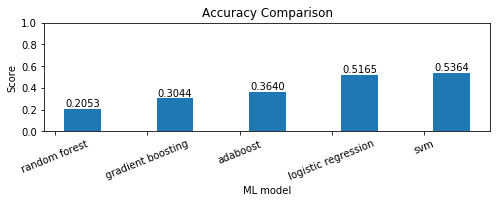

In [101]:
import operator
tup_results = sorted(dic_results.items(), key=operator.itemgetter(1))

N = len(dic_results)
ind = np.arange(N)  # the x locations for the groups
width = 0.40       # the width of the bars

fig = plt.figure(figsize=(8,2))
ax = fig.add_subplot(111)
rects = ax.bar(ind+0.5, list(zip(*tup_results))[1], width,)
for rect in rects:
    height = rect.get_height()
    ax.text(rect.get_x()+rect.get_width()/2., 
            1.005*height, 
            '{0:.4f}'.format(height), 
            ha='center', 
            va='bottom',)

ax.set_ylabel('Score')
ax.set_xlabel('ML model')
ax.set_ylim(ymin=0.0,ymax = 1)
ax.set_title("Recall Comparison")
ax.set_xticks(ind + width/2.)
ax.set_xticklabels(list(zip(*tup_results))[0], rotation=22)

plt.show()

# calculate final quality with a test set
So we see that the best validated model is Logistic Regression. We will now test it on the test set. We could also compare with other models with their respective best params.

### transform data

In [122]:
#transform X_train
scale = StandardScaler().fit(X_train)
X_train_scaled = scale.transform(X_train)

#transform X_test
scale = StandardScaler().fit(X_test)
X_test_scaled = scale.transform(X_test)

### get best params of regressor
this was previously obtained during cross validation step

In [120]:
params_normal = {}
for k,v in logreg_best.items():
    k = k[8:]
    params_normal[k] = v
params_normal

{'C': 8.858667904100833e-05, 'penalty': 'l2', 'random_state': 42}

In [139]:
#instantiate regressor with best params
params = params_normal
clf_logreg_validated = LogisticRegression(C = params['C'], penalty = params['penalty'], random_state = params['random_state'])

clf_logreg_validated.fit(X_train_scaled, y_train)
y_pred = clf_logreg_validated.predict(X_test_scaled)

### calculate accuracy on test set

In [132]:
accuracy_score(y_test, y_pred)

0.7433333333333333

### classification report

In [133]:
print("\nCLASSIFICATION_REPORT:\n", classification_report(y_test, y_pred))


CLASSIFICATION_REPORT:
               precision    recall  f1-score   support

           0       0.87      0.80      0.84       244
           1       0.36      0.48      0.41        56

    accuracy                           0.74       300
   macro avg       0.62      0.64      0.62       300
weighted avg       0.78      0.74      0.76       300



### repeat for oversampled model

In [134]:
params_smote = {}
for k,v in logreg_best_smote.items():
    k = k[8:]
    params_smote[k] = v
params_smote

{'C': 1.1288378916846884, 'penalty': 'l2', 'random_state': 42}

In [135]:
#instantiate regressor with best params
params = params_smote
clf_logreg_validated = LogisticRegression(C = params['C'], penalty = params['penalty'], random_state = params['random_state'])

clf_logreg_validated.fit(X_train_scaled, y_train)
y_pred = clf_logreg_validated.predict(X_test_scaled)

In [136]:
accuracy_score(y_test, y_pred)

0.8466666666666667

In [137]:
print("\nCLASSIFICATION_REPORT:\n", classification_report(y_test, y_pred))


CLASSIFICATION_REPORT:
               precision    recall  f1-score   support

           0       0.90      0.92      0.91       244
           1       0.60      0.54      0.57        56

    accuracy                           0.85       300
   macro avg       0.75      0.73      0.74       300
weighted avg       0.84      0.85      0.84       300



# draft

### temp test with rfc

In [45]:
params = {}
for k,v in clf_rforest.best_params_.items():
    k = k[5:]
    params[k] = v
params

{'max_features': None, 'n_estimators': 300, 'random_state': 42}

In [46]:
#transform X_train
scale = StandardScaler().fit(X_train)
X_train_scaled = scale.transform(X_train)

#transform X_test
scale = StandardScaler().fit(X_test)
X_test_scaled = scale.transform(X_test)

#instantiate regressor with best params
clf_rfc_validated = RandomForestClassifier(max_features = params['max_features'], n_estimators = params['n_estimators'], random_state = params['random_state'])

#fit regressor
clf_rfc_validated.fit(X_train_scaled, y_train)

#do prediction on test set
y_pred = clf_rfc_validated.predict(X_test_scaled)

### calculate accuracy on test set

In [47]:
accuracy_score(y_test, y_pred)

0.8233333333333334

### classification report

In [48]:
print("\nCLASSIFICATION_REPORT:\n", classification_report(y_test, y_pred))


CLASSIFICATION_REPORT:
               precision    recall  f1-score   support

           0       0.85      0.95      0.90       244
           1       0.55      0.29      0.38        56

    accuracy                           0.82       300
   macro avg       0.70      0.62      0.64       300
weighted avg       0.80      0.82      0.80       300

